In [7]:
import os
from dotenv import load_dotenv
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
GOOGLE_MODEL_NAME = os.getenv("GOOGLE_MODEL_NAME", "gemini-pro") 

from langchain_google_genai import ChatGoogleGenerativeAI

In [8]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, ChatMessage



In [9]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import os

def load_document_content(file_path):
    try:
        # Load documents from the file using TextLoader
        loader = TextLoader(file_path)
        documents = loader.load()

        # Split text into smaller chunks
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
        docs = text_splitter.split_documents(documents)

        # Concatenate the chunks into a single context string
        context = "\n".join([doc.page_content for doc in docs])
        return context
    except Exception as e:
        return f"Error loading document content: {e}"

file_name = 'topic_material.txt'
file_path = os.path.join("data", file_name)
context = load_document_content(file_path)



In [10]:
context

'Topic: Polymorphism in Java, Abstract classes, Interfaces\nIn the previous lectures you learned how to create and use new classes (data abstraction), and how to derive a class from an existing class (inheritance). In this lecture we will learn about Polymorphism, which is the third essential feature of OOP programming. While the inheritance promotes reusability, the polymorphism allows developers to write code that does not depend on a specific type of objects. Polymorphic behavior In the BasePlusCommisionEmployee\tCommissionEmployee example, you noticed that method toString() behaved differently when we applied that method to different objects (CommissionEmployee and BasePlusCommisionEmployee). When a method behaves differently when itâ€™s applied to different objects, this is called a polymorphic behavior. In a large number of problems there is always a situation, in which for a given entity you may define a generic behavior, and then\nredefine it for more specialized entities that 

In [11]:
GREETING_PROMPT = """
You are an AI Tutor. You are given a topic and a subject.
You need to create a greeting message for the student and ask them what they want to learn based on the subject and topic.
Keep the greeting short and concise.

Subject: {subject}
Topic: {topic}
"""

QUESTION_GUARDING_PROMPT = """
You are an AI Tutor. Based on the content of the topic, 
you need to decide if the student's question is related to the topic.
For educational purpose, it is ok to be related but not exactly the same topic.
If it is, respond "Pass".  
If it is not, respond "Fail" 

Student Question: {question}
Content of the topic: {context}
"""

QUESTION_ANSWERING_PROMPT = """
You are an AI Tutor. You are given a question and a topic.
You need to answer the question based on the context.

Question: {question}
Context: {context}
"""




In [30]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages


llm = ChatGoogleGenerativeAI(model="gemini-pro")

class AgentState(TypedDict):
    subject: str
    topic: str
    context: str
    messages: Annotated[list, add_messages]

def greeting(state: AgentState):
    subject = state["subject"]
    topic = state["topic"]
    messages = state["messages"]

    greeting_prompt = GREETING_PROMPT.format(subject=subject, topic=topic)
    messages= [HumanMessage(content=greeting_prompt.format(subject=subject, topic=topic))]
    response = llm.invoke(messages)
    return {"messages": response}


def question_guarding(state:AgentState):
    print("Question guarding: ", state["messages"][-1].content)
    question = state["messages"][-1].content
    response = llm.invoke(QUESTION_GUARDING_PROMPT.format(question=question, context=context))
    content = response.content
    if content.startswith("Pass"):
        print("Pass")
        return "Pass"
    # elif content.startswith("Fail:"):
    #     follow_up_question = content.split(":")[1]
    #     # return {"messages": [AIMessage(content=follow_up_question)]}
    #     # state["messages"].append(AIMessage(content=follow_up_question))
    #     return "Fail"

    else:
        print("Fail")
        # follow_up_question = content.split(":")[1]
        # state["messsage"].append(AIMessage(content=follow_up_question))
        return "Fail"
        # return {"messages": [HumanMessage(content="Check again for pass or fail question!")]}

def student_input(state:AgentState):
    print(state["messages"][-1].content)
    return state


def answer_question(state:AgentState):
    # print("Answer the question: ", state["messages"][-1].content)
    question = state["messages"][-1].content
    response = llm.invoke(QUESTION_ANSWERING_PROMPT.format(question=question, context = context))
    result=response.content
    return {"messages": [AIMessage(content=result)]}




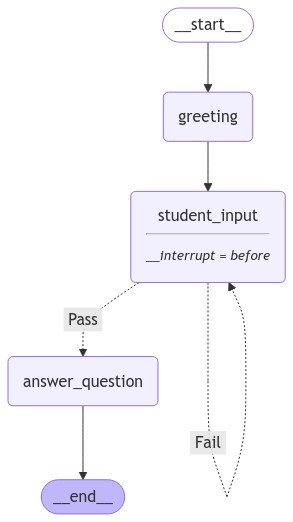

In [31]:
from langgraph.graph import START,END, StateGraph

workflow = StateGraph(AgentState)

workflow.add_node("greeting", greeting)
workflow.add_node("student_input", student_input)
# workflow.add_node("question_guarding", question_guarding)
workflow.add_node("answer_question", answer_question)


workflow.add_edge(START, "greeting")
workflow.add_edge("greeting", "student_input")
# workflow.add_edge("student_input", "question_guarding")

workflow.add_conditional_edges(
    "student_input",
    question_guarding,
    {
        "Pass": "answer_question",
        "Fail": "student_input"
    }
)

workflow.add_edge("answer_question", END)
# workflow.add_edge("student_input", "question_guarding")

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
app = workflow.compile(checkpointer=memory, interrupt_before=["student_input"])

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))


In [32]:
# Input
initial_input = {"subject":"Java", "topic": "Polymorphism in Java"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in app.stream(initial_input, thread, stream_mode="values"):
    print(event)

{'subject': 'Java', 'topic': 'Polymorphism in Java', 'messages': []}
{'subject': 'Java', 'topic': 'Polymorphism in Java', 'messages': [AIMessage(content="Hello! Welcome to your Java tutoring session. Today, we'll be discussing polymorphism in Java. What specific aspects of polymorphism would you like to learn more about?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-e1c59e6b-3bae-430f-8254-a5426153c094-0', usage_metadata={'input_tokens': 63, 'output_tokens': 33, 'total_tokens': 96})]}


In [33]:
# Get user input
# try:
#     user_input = input("Ask question:")
# except:
user_input = "what is Polymorphism?"

# We now update the state as if we are the student_input node
app.update_state(thread, {"messages": HumanMessage(content=user_input)}, as_node="student_input")

# We can check the state
print("--State after update--")
print(app.get_state(thread))



Question guarding:  what is Polymorphism?
Pass
--State after update--
StateSnapshot(values={'subject': 'Java', 'topic': 'Polymorphism in Java', 'messages': [AIMessage(content="Hello! Welcome to your Java tutoring session. Today, we'll be discussing polymorphism in Java. What specific aspects of polymorphism would you like to learn more about?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-e1c59e6b-3bae-430f-8254-a5426153c094-0', usage_metadata={'input_tokens': 63, 'output_tokens': 33, 'total_tokens': 96}), Human

In [144]:
# We can check the next node, showing that it is node 3 (which follows human_feedback)
app.get_state(thread).next

('student_input',)

In [145]:
app.get_state(thread).values


{'subject': 'Java',
 'topic': 'Polymorphism in Java',
 'messages': [AIMessage(content="Greetings, young Java enthusiast!\n\nI am your AI tutor, here to guide you through the fascinating world of polymorphism.\n\nPolymorphism is a fundamental concept in Java that allows you to write code that can behave differently depending on the object it's working with. It's a powerful tool that can help you create flexible and reusable code.\n\nWhat specifically would you like to learn about polymorphism in Java? Feel free to ask me any questions you have, and I'll do my best to provide you with clear and concise answers.\n\nLet's dive into the world of polymorphism together!", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': F

In [34]:
for event in app.stream(None, thread, stream_mode="values"):
    # print(event)
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is Polymorphism?
================================== Ai Message ==================================

Polymorphism is the ability of an object to take on multiple forms. In Java, polymorphism is achieved through inheritance and interfaces.

When a subclass inherits from a superclass, it can override methods of the superclass. This means that the subclass can provide its own implementation of the method, which can be different from the implementation in the superclass.

Interfaces are another way to achieve polymorphism in Java. An interface defines a set of methods that a class must implement. A class can implement multiple interfaces, and each interface can define its own set of methods.

Polymorphism is a powerful tool that can be used to make code more flexible and reusable. By using polymorphism, you can write code that can work with different types of objects without having to rewrite the code for 